In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import curve_fit
from astropy import constants as const
from scipy.optimize import curve_fit
import warnings
from imblearn.over_sampling import SMOTE
from scipy.stats import bootstrap
import scipy
import matplotlib.mlab as mlab

warnings.filterwarnings("ignore")

dataLI = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\STPM_improved_210721.csv",delimiter=",")
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
dataLI["planet_name"] = planet_name_LI
dataEA = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\Exoplanet_Archive.csv",delimiter=",")
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
dataLI["planet_name"] = planet_name_LI


earth_like_rocky  = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\Mass_Radius_Curves\Earth-like Rocky (32.5% Fe+67.5% MgSiO3).txt",delimiter = "\t")
pure_rock         = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\Mass_Radius_Curves\pure-Rock (100% MgSiO3).txt",delimiter = "\t")
H20_50_300K       = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_300 K_1mili-bar surface temprture.txt",delimiter = "\t")
H20_50_500K       = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_500 K_1mili-bar surface temprture.txt",delimiter = "\t")
H20_50_700K       = pd.read_csv(r"C:\Users\silke\OneDrive\Skrivebord\Thesis\Mass_Radius_Curves\50% H2O (50% Earth-like rocky core + 50% H2O layer by mass)_700 K_1mili-bar surface temprture.txt",delimiter = "\t")


In [ ]:
spline fitting
fit line better - lin/lin - log/log - exponential? fit log(x) instead of x
add new data!!! :D

## Setup

In [3]:
# Luque Impoved
planet_id_LI         = dataLI.ID
star_name_LI         = dataLI.Star
planet_letter_LI     = dataLI.Planet

radius_LI            = dataLI.R_Rterra            # [Earth Radius]
radius_unc_up_LI     = dataLI.euR_Rterra          # [Earth Radius] Upper Unc.
radius_unc_low_LI    = dataLI.edR_Rterra          # [Earth Radius] Lower Unc.

mass_LI              = dataLI.M_Mterra            # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_LI       = dataLI.euM_Mterra          # [Earth Mass] Upper Unc.
mass_unc_low_LI      = dataLI.edM_Mterra          # [Earth Mass] Lower Unc.

density_LI           = dataLI[dataLI.columns[32]]  # [g/cm**3]
density_unc_up_LI    = dataLI[dataLI.columns[33]]  # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_LI   = dataLI[dataLI.columns[34]]  # [g/cm**3] Planet Density Lower Unc

pl_eq_LI             = dataLI.Teq_K                # [K] Equilibrium Temperature


# Exoplanet Archive
planet_name_EA       = dataEA.pl_name
planet_id_EA         = list(range(0,len(planet_name_EA)))

radius_EA            = dataEA.pl_rade            # [Earth Radius]
period_EA            = dataEA.pl_orbper          # [days]
radius_unc_up_EA     = dataEA.pl_radeerr1        # [Earth Radius] Upper Unc.
radius_unc_low_EA    = dataEA.pl_radeerr2        # [Earth Radius] Lower Unc.
mass_EA              = dataEA.pl_bmasse          # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]

mass_unc_up_EA       = dataEA.pl_bmasseerr1      # [Earth Mass] Upper Unc.
mass_unc_low_EA      = dataEA.pl_bmasseerr2      # [Earth Mass] Lower Unc.

density_EA           = dataEA.pl_dens            # [g/cm**3]
density_unc_up_EA    = dataEA.pl_denserr1        # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_EA   = dataEA.pl_denserr2        # [g/cm**3] Planet Density Lower Unc. 
st_spectype_EA       = dataEA.st_spectype        # Spectral type of star
pl_eq_EA             = dataEA.pl_eqt             # [K] Equilibrium Temperature

## Filters

In [4]:
# base1 filter
def base1(mass,mass_unc_up,mass_unc_low,radius,radius_unc_up,radius_unc_low,st_spectype,planet_id):
    STPM_candidate_id = []
    for i in planet_id_EA:
        relative_uncertainty_mass = (mass_unc_up[i] - mass_unc_low[i]) / (2 * mass[i])
        relative_uncertainty_radius = (radius_unc_up[i] - radius_unc_low[i]) / (2 * radius[i])
        if relative_uncertainty_mass <= 0.25 and relative_uncertainty_radius <= 0.08 and radius[i] <4 and isinstance(st_spectype[i],str) and "M" in st_spectype[i]:
            STPM_candidate_id.append(planet_id_EA[i])
    return STPM_candidate_id
#print(len(STPM_candidate_id),len(old_STPM_candidate),len(new_STPM_candidate),list(planet_name[STPM_candidate_id]))

In [5]:
def base2(mass,mass_unc_up,mass_unc_low,radius,radius_unc_up,radius_unc_low,st_spectype,planet_id):
    STPM_candidate_id = []
    for i in planet_id_EA:
        if mass_unc_up[i]/mass[i] <= 0.25 and abs(mass_unc_low[i])/mass[i] <= 0.25 and radius_unc_up[i]/radius[i] <= 0.08 and abs(radius_unc_low[i])/radius[i] <= 0.08 and radius[i] <4 and isinstance(st_spectype[i],str) and "M" in st_spectype[i]:
           STPM_candidate_id.append(planet_id_EA[i])
    return STPM_candidate_id



In [6]:
STPM_id_base1 = base1(mass_EA,mass_unc_up_EA,mass_unc_low_EA,radius_EA,radius_unc_up_EA,radius_unc_low_EA,st_spectype_EA,planet_id_EA)
STPM_id_base2 = base2(mass_EA,mass_unc_up_EA,mass_unc_low_EA,radius_EA,radius_unc_up_EA,radius_unc_low_EA,st_spectype_EA,planet_id_EA)
print(len(STPM_id_base1),"in base1,",len(STPM_id_base2),"in base 2.")
print("Planets in base1 and not in base 2:\n",planet_name_EA[list(set(STPM_id_base1) - set(STPM_id_base2))])

46 in base1, 44 in base 2.
Planets in base1 and not in base 2:
 2449    Kepler-138 c
4994      TOI-1695 b
Name: pl_name, dtype: object


In [7]:
# Luque filter
log_planets_id    = [47, 48, 184, 189, 190, 214, 231, 232, 236, 240, 244, 258, 261, 941, 942, 1351, 1352, 1400, 1504, 1568, 1569, 2128, 2129, 2449, 2450, 2451, 3455, 3456, 4600, 4675, 4677, 4678, 4679, 4681, 4682, 4683, 4686, 4688, 4690, 4691, 4695, 4696, 4697, 4698, 4922, 4933, 4937, 4938, 4950, 4951, 4972, 4973, 4974, 4975, 4976, 4984, 4990, 4995, 4999, 5003, 5036, 5064, 5083, 5084, 5085, 5086, 5190, 5191, 5210, 5211, 5212, 5213, 5214, 5215, 5216]
in_luque_imp      = ["y", "n", "y", "y", "y", "n", "y", "y", "y", "n", "n", "y", "y", "n", "n", "y", "y", "y", "y", "y", "y", "n", "n", "y", "y", "y", "n", "n", "n", "y", "n", "y", "y", "y", "y", "y", "y", "y", "n", "n", "n", "n", "y", "y", "n", "n", "y", "y", "y", "y", "n", "n", "n", "n", "n", "y", "y", "n", "y", "n", "n", "n", "y", "y", "y", "y", "y", "y", "y", "y", "y", "y", "y", "y", "y"]
log_id            = [x - 1 for x in log_planets_id]
luque_imp_names   = []
luque_log_index   = []
for i in range(0,len(log_planets_id)):
    if in_luque_imp[i] == "y":
        luque_imp_names.append(planet_name_EA[log_planets_id[i]-1])
        luque_log_index.append(log_planets_id[i]-1)

## Statistical analysis

In [8]:
planet = "L 98-59 d"

def find_index(planet_name):
    index = planet_name_LI.index(planet_name)
    return index

index  = find_index(planet)

relative_uncertainty_mass = (mass_unc_low_LI[index] + mass_unc_up_LI[index]) / (2 * mass_LI[index])
relative_uncertainty_radius = (radius_unc_up_LI[index] + radius_unc_low_LI[index]) / (2 * radius_LI[index])
print("radius:",radius_LI[index])
print("mass unc 25%:",relative_uncertainty_mass)
print("radius unc 8%:",relative_uncertainty_radius)


radius: 1.58
mass unc 25%: 0.19696969696969696
radius unc 8%: 0.05063291139240506


## Plot Exoplanet Archive Planets in base1 and base2

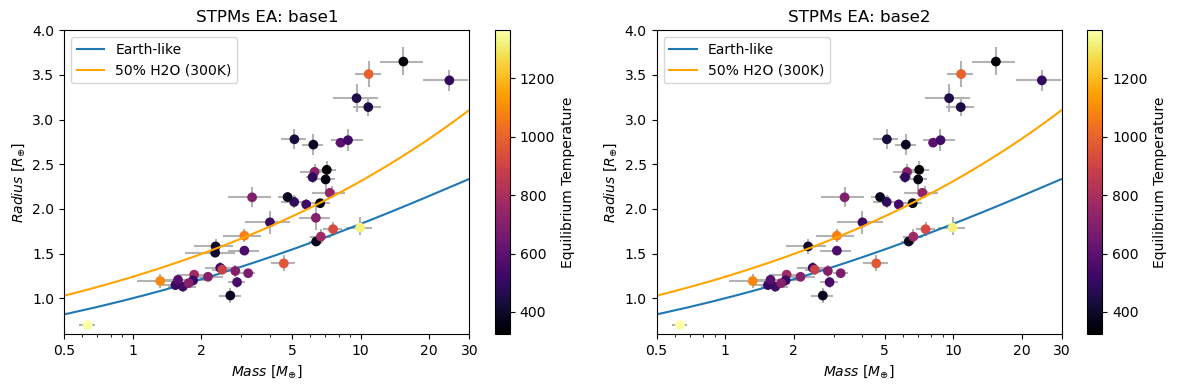

In [9]:
plt.figure(figsize=(12, 4))  # Adjust the figure size as needed

# Plot base1
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
STPM_candidate_id = STPM_id_base1
mass_up_lim    = abs(dataEA.pl_bmasseerr2[STPM_candidate_id])
mass_low_lim   = abs(dataEA.pl_bmasseerr1[STPM_candidate_id])
mass_err       = [mass_low_lim,mass_up_lim]
radius_up_lim  = dataEA.pl_radeerr1[STPM_candidate_id]
radius_low_lim = abs(dataEA.pl_radeerr2[STPM_candidate_id])
radius_err     = [radius_low_lim,radius_up_lim]
plt.errorbar(mass_EA[STPM_candidate_id], radius_EA[STPM_candidate_id],xerr = mass_err, yerr=radius_err,fmt='.', color='0.7',zorder=-32)
plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",label = "Earth-like",zorder=-32)
mass_lists_h20 = np.linspace(0,1,100)
x = 0.5
radus_list_h20 = (1+0.55*x-0.14*x**2)* mass_lists_h20**(1/3.7)
plt.plot(mass_lists_h20,radus_list_h20,"-",color = "orange",label = "50% H2O (300K)",zorder=-32)
mass_lists_h20 = np.linspace(1,30,100)
x = 0.5
radus_list_h20 = (1+0.55*x-0.14*x**2)* mass_lists_h20**(1/3.7)
plt.plot(mass_lists_h20,radus_list_h20,"-",color = "orange")

has_temp_eq_id = []
for i in STPM_candidate_id:
    if pl_eq_EA[i] != "NaN":
        has_temp_eq_id.append(i)

# Create a colorscale based on the equilibrium temperature
norm = plt.Normalize(pl_eq_EA[has_temp_eq_id].min(), pl_eq_EA[has_temp_eq_id].max())
cmap = plt.cm.get_cmap('inferno')
plt.scatter(mass_EA[has_temp_eq_id], radius_EA[has_temp_eq_id], c=pl_eq_EA[has_temp_eq_id], cmap=cmap, norm=norm, marker='o')
cbar = plt.colorbar()
cbar.set_label('Equilibrium Temperature')
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log")
plt.xlim(0.5,30)
plt.ylim(min(radius_EA[STPM_candidate_id])-0.1,4)
plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False)
plt.legend()
plt.title("STPMs EA: base1")

# Plot base2
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
STPM_candidate_id = STPM_id_base2
mass_up_lim    = abs(dataEA.pl_bmasseerr2[STPM_candidate_id])
mass_low_lim   = abs(dataEA.pl_bmasseerr1[STPM_candidate_id])
mass_err       = [mass_low_lim,mass_up_lim]
radius_up_lim  = dataEA.pl_radeerr1[STPM_candidate_id]
radius_low_lim = abs(dataEA.pl_radeerr2[STPM_candidate_id])
radius_err     = [radius_low_lim,radius_up_lim]
plt.errorbar(mass_EA[STPM_candidate_id], radius_EA[STPM_candidate_id],xerr = mass_err, yerr=radius_err,fmt='.', color='0.7',zorder=-32)

plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",label = "Earth-like",zorder=-32)
mass_lists_h20 = np.linspace(0,1,100)
x = 0.5
radus_list_h20 = (1+0.55*x-0.14*x**2)* mass_lists_h20**(1/3.7)
plt.plot(mass_lists_h20,radus_list_h20,"-",color = "orange",label = "50% H2O (300K)",zorder=-32)
mass_lists_h20 = np.linspace(1,30,100)
x = 0.5
radus_list_h20 = (1+0.55*x-0.14*x**2)* mass_lists_h20**(1/3.7)
plt.plot(mass_lists_h20,radus_list_h20,"-",color = "orange")

has_temp_eq_id = []
for i in STPM_candidate_id:
    if pl_eq_EA[i] != "NaN":
        has_temp_eq_id.append(i)
has_temp_eq_id = []
for i in STPM_candidate_id:
    if pl_eq_EA[i] != "NaN":
        has_temp_eq_id.append(i)

# Create a colorscale based on the equilibrium temperature
norm = plt.Normalize(pl_eq_EA[has_temp_eq_id].min(), pl_eq_EA[has_temp_eq_id].max())
cmap = plt.cm.get_cmap('inferno')
plt.scatter(mass_EA[has_temp_eq_id], radius_EA[has_temp_eq_id], c=pl_eq_EA[has_temp_eq_id], cmap=cmap, norm=norm, marker='o')
cbar = plt.colorbar()
cbar.set_label('Equilibrium Temperature')
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log")
plt.xlim(0.5,30)
plt.ylim(min(radius_EA[STPM_candidate_id])-0.1,4)
plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False)
plt.legend()
plt.title("STPMs EA: base2")

plt.tight_layout()
plt.show()


## Plot Luque improved sample - All Planets

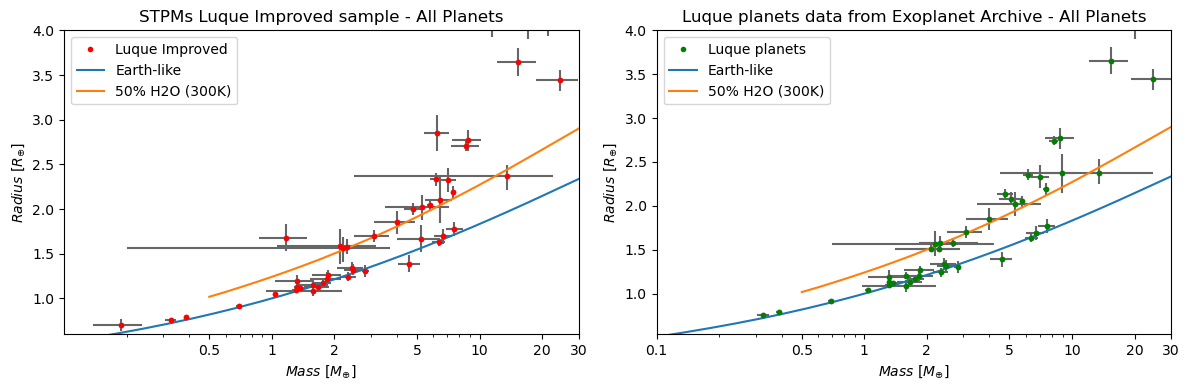

In [10]:
plt.figure(figsize=(12, 4))  # Adjust the figure size as needed

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
mass_err_LI       = [mass_unc_up_LI,mass_unc_low_LI]
radius_err_LI     = [radius_unc_up_LI,radius_unc_low_LI]
plt.plot(mass_LI,radius_LI,'r.',label = "Luque Improved")
plt.errorbar(mass_LI, radius_LI,xerr = mass_err_LI, yerr=radius_err_LI,fmt='.', color='0.4',zorder=-32)

plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",label = "Earth-like",zorder=-32)
plt.plot(list(H20_50_300K["Mass"]),list(H20_50_300K["Radius"]),"-",label = "50% H2O (300K)",zorder=-32)

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log")
plt.xlim(0.1,30)
plt.ylim(min(radius_LI)-0.1,4)
plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False)
plt.legend()
plt.title("STPMs Luque Improved sample - All Planets")

plt.subplot(1, 2, 2)
mass_up_lim_EA     = dataEA.pl_bmasseerr1[luque_log_index]
mass_low_lim_EA    = abs(dataEA.pl_bmasseerr2[luque_log_index])
mass_err_EA        = [mass_low_lim_EA ,mass_up_lim_EA]
radius_up_lim_EA   = dataEA.pl_radeerr1[luque_log_index]
radius_low_lim_EA  = abs(dataEA.pl_radeerr2[luque_log_index])
radius_err_EA      = [radius_low_lim_EA ,radius_up_lim_EA ]
plt.plot(mass_EA[luque_log_index],radius_EA[luque_log_index],'g.',label = "Luque planets")
plt.errorbar(mass_EA[luque_log_index], radius_EA[luque_log_index],xerr = mass_err_EA, yerr=radius_err_EA,fmt='.', color='0.4',zorder=-32)

plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",label = "Earth-like",zorder=-32)
plt.plot(list(H20_50_300K["Mass"]),list(H20_50_300K["Radius"]),"-",label = "50% H2O (300K)",zorder=-32)

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log")
plt.xlim(0.2,30)
plt.ylim(min(radius_EA[luque_log_index])-0.1,4)
plt.xticks([0.1,0.5,1,2,5,10,20, 30],["0.1","0.5","1","2","5","10","20", "30"],minor=False)
plt.legend()
plt.title("Luque planets data from Exoplanet Archive - All Planets")

plt.tight_layout()
plt.show()

## Luque - 34 planets found visually

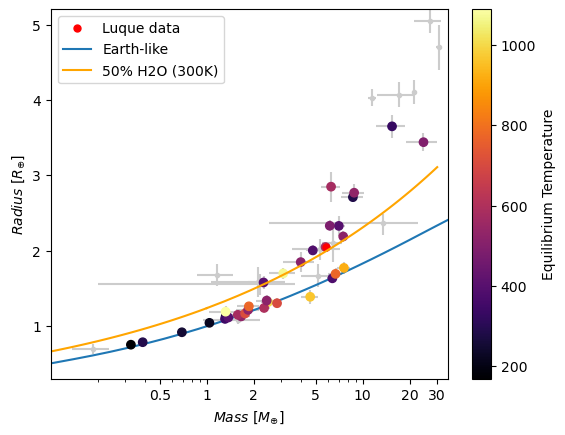

In [14]:

planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']
marked            = False
mark              = ["GJ 1132 b","GJ 1214 b","GJ 1252 b","L 98-59 d"]
mass_err_LI       = [mass_unc_up_LI,mass_unc_low_LI]
radius_err_LI     = [radius_unc_up_LI,radius_unc_low_LI]

mass_err_LI       = [mass_unc_up_LI,mass_unc_low_LI]
radius_err_LI     = [radius_unc_up_LI,radius_unc_low_LI]
index_list        = []
plt.errorbar(mass_LI, radius_LI,xerr = mass_err_LI, yerr=radius_err_LI,fmt='.',color = "0.8",zorder=-32)
#print("planet\t radius\t mass")

def find_index(planet_name):
    index = planet_name_LI.index(planet_name)
    return index

for i in range(0,len(planets)):
    planet  = planets[i]
    index   = find_index(planet)
    index_list.append(index)
    # print(planet,radius_LI[index],mass_LI[index])
    if i == 0:
        plt.plot(mass_LI[index], radius_LI[index],'.',color = "r",markersize = 10,label= "Luque data")
    else:
        pass
        #plt.plot(mass_LI[index], radius_LI[index],'.',color = "r",markersize = 10)

    # plt.plot(mass_LI[index], radius_LI[index],'.', c=np.random.rand(3,),markersize = 10)

    
plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",label = "Earth-like",zorder=-32)
mass_lists_h20 = np.linspace(0,1,100)
x = 0.5
radus_list_h20 = (1+0.55*x-0.14*x**2)* mass_lists_h20**(1/3.7)
plt.plot(mass_lists_h20,radus_list_h20,"-",color = "orange",label = "50% H2O (300K)",zorder=-32)
mass_lists_h20 = np.linspace(1,30,100)
x = 0.5
radus_list_h20 = (1+0.55*x-0.14*x**2)* mass_lists_h20**(1/3.7)
plt.plot(mass_lists_h20,radus_list_h20,"-",color = "orange")

has_temp_eq_id = []
for i in STPM_candidate_id:
    if pl_eq_EA[i] != "NaN":
        has_temp_eq_id.append(i)
has_temp_eq_id = []
for i in index_list:
    if pl_eq_EA[i] != "NaN":
        has_temp_eq_id.append(i)

norm = plt.Normalize(pl_eq_LI[has_temp_eq_id].min(), pl_eq_LI[has_temp_eq_id].max())
cmap = plt.cm.get_cmap('inferno')
plt.scatter(mass_LI[has_temp_eq_id], radius_LI[has_temp_eq_id], c=pl_eq_LI[has_temp_eq_id], cmap=cmap, norm=norm, marker='o')
cbar = plt.colorbar()
cbar.set_label('Equilibrium Temperature')

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log")
plt.xlim(0.1,35)
plt.ylim(0.3,5.2)
plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False)
leg = plt.legend()


## Density plots - Fit and plot

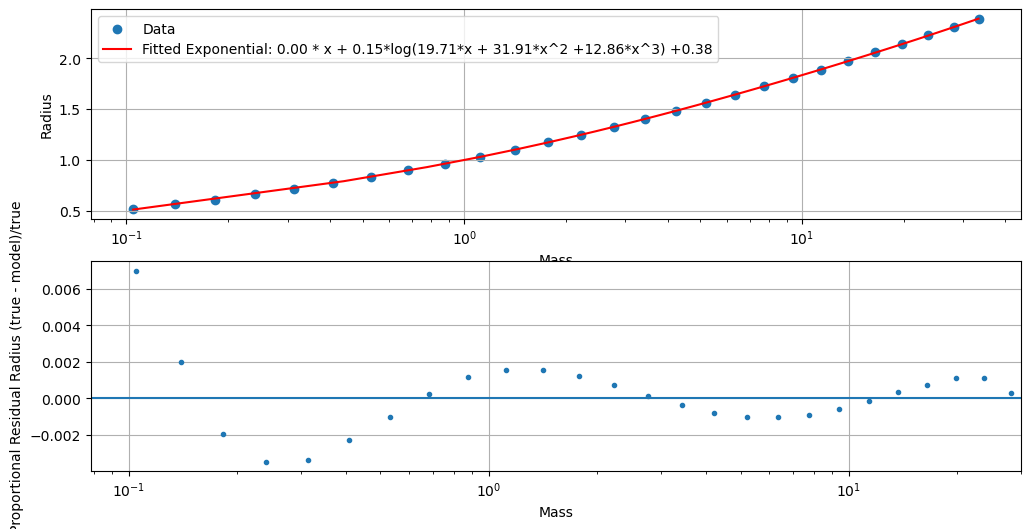

In [12]:
earth_density    = 5.51   # [g/cm**3]
Earth_Mass       = 5.972*10e27 # g
Earth_Radius     = 6.371*10e8  # cm
Earth_Volume     = 1.08321*10e27

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.subplot(2, 1, 1)  # 1 row, 2 columns, first subplot
radius_data = earth_like_rocky["Radius"]  
mass_data   = earth_like_rocky["Mass"]  # Mass data
earth_like_rocky_radius = []
earth_like_rocky_mass   = []
for i in range(0,len(mass_data)):
    if mass_data[i] < 35 and mass_data[i]> 0.1 :
        earth_like_rocky_radius.append(radius_data[i])
        earth_like_rocky_mass.append(mass_data[i])

def predict_radius(mass, a, b,c,d,f,g):
    return a*mass+b*np.log(mass*c+d*mass**2+f*mass**3)+g

params, covariance = curve_fit(predict_radius,earth_like_rocky_mass,earth_like_rocky_radius)
a_fit, b_fit, c_fit,d_fit,f_fit,g_fit= params
x_range = np.linspace(min(earth_like_rocky_mass), max(earth_like_rocky_mass), 100)
y_fit = predict_radius(x_range, a_fit, b_fit,c_fit,d_fit,f_fit,g_fit)

def calculate_density(exoplanet_mass, exoplanet_radius):
    return Earth_Mass*exoplanet_mass / (Earth_Volume*(exoplanet_radius**3))

# Plot the original data and the fitted exponential function
plt.scatter(earth_like_rocky_mass,earth_like_rocky_radius, label='Data')
plt.plot(x_range, y_fit, 'r-', label=f'Fitted Exponential: {a_fit:.2f} * x + {b_fit:.2f}*log({c_fit:.2f}*x + {d_fit:.2f}*x^2 +{f_fit:.2f}*x^3) +{g_fit:.2f}')
#plt.plot(x_range, y_fit, 'r-')

plt.ylabel('Radius')
plt.xlabel('Mass')
plt.legend()
#plt.xlim(-0.2,30)
plt.grid(True)
plt.xscale("log")

plt.subplot(2, 1, 2)  # 1 row, 2 columns, first subplot

plt.plot(earth_like_rocky_mass,(earth_like_rocky_radius-predict_radius(np.array(earth_like_rocky_mass),a_fit, b_fit, c_fit,d_fit,f_fit,g_fit))/earth_like_rocky_radius,".")
plt.ylabel('Proportional Residual Radius (true - model)/true')
plt.xlabel('Mass')
plt.xscale("log")
plt.xlim(-0.2,30)
plt.grid(True)
plt.hlines(0,-5,35)

Series([], Name: R_Rterra, dtype: float64) Series([], Name: M_Mterra, dtype: float64)


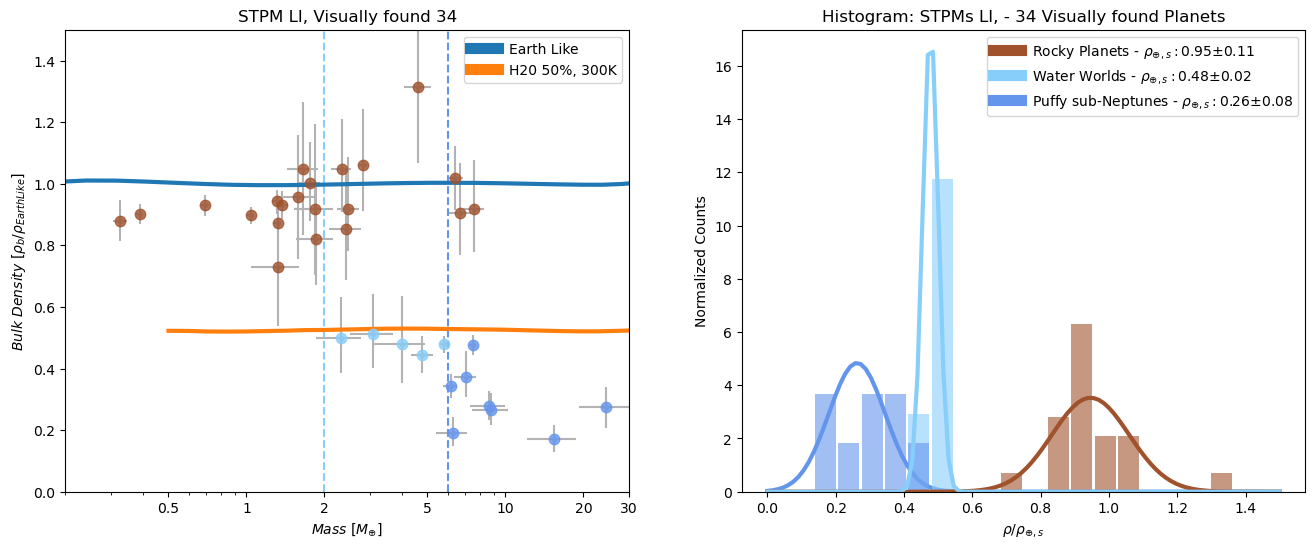

21 5 8


In [47]:
plt.figure(figsize=(16, 6))  # Adjust the figure size as needed
plt.subplot(1,2,1)
radius_data = earth_like_rocky["Radius"]  
mass_data   = earth_like_rocky["Mass"]  # Mass data
predict_radius(mass_data, a_fit, b_fit,c_fit,d_fit,f_fit,g_fit)

density_true     = calculate_density(earth_like_rocky["Mass"],earth_like_rocky["Radius"])
mass_list        = mass_data
radius_list      = predict_radius(mass_data, a_fit, b_fit,c_fit,d_fit,f_fit,g_fit)
density_normal   = calculate_density(mass_list,radius_list)
plt.plot(earth_like_rocky["Mass"],density_true/density_normal,"-",label = "Earth Like",linewidth=3)
earth_like_mean_density = np.mean(density_true/density_normal)
radius_data = H20_50_300K["Radius"]  
mass_data   = H20_50_300K["Mass"]  # Mass data
H2O_50_300K_radius = []
H2O_50_300K_mass   = []
for i in range(0,len(radius_data)):
    if mass_data[i] < 35:
        H2O_50_300K_radius.append(radius_data[i])
        H2O_50_300K_mass.append(mass_data[i])

density_true     = []
radius_list      = []  
mass_list        = H2O_50_300K_mass
density_normal   = []
densities        = []
for i in range(0,len(H2O_50_300K_mass)):
    density_true.append(calculate_density(H2O_50_300K_mass[i],H2O_50_300K_radius[i]))
    radius_list.append(predict_radius(mass_list[i],a_fit, b_fit,c_fit,d_fit,f_fit,g_fit))
    density_normal.append(calculate_density(mass_list[i],radius_list[i]))
    densities.append(density_true[i]/density_normal[i])
plt.plot(H2O_50_300K_mass,densities,"-",label = "H20 50%, 300K",linewidth=3)
H2O_50_300K_mass_mean_density = np.mean(densities)
density_true     = []
radius_list      = []  
mass_list        = list(mass_LI[index_list])
density_normal   = []
densities        = []

index_rocky      = []
rocky_density    = []
rocky_mass       = []
index_water      = []
water_density    = []
water_mass       = []
index_puffy      = []
puffy_density    = []
puffy_mass       = []
name_puffy       = []

print(radius_LI[index_puffy],mass_LI[index_puffy])


for i in range(0,len(list(mass_LI[index_list]))):
    density_true.append(list(density_LI[index_list])[i])
    radius_list.append(predict_radius(mass_list[i],a_fit, b_fit,c_fit,d_fit,f_fit,g_fit))
    density_normal.append(calculate_density(mass_list[i],radius_list[i]))
    densities.append(density_true[i]/density_normal[i])
    dist_H2O = density_true[i]/density_normal[i] - H2O_50_300K_mass_mean_density
    dist_EL  = earth_like_mean_density - density_true[i]/density_normal[i]
    if mass_list[i] < 2 or dist_EL < dist_H2O:
        name_rocky = planets[i]
        index = find_index(name_rocky)
        index_rocky.append(index)
        rocky_density.append(density_true[i]/density_normal[i])
        rocky_mass.append(mass_list[i])
    if 2 < mass_list[i] < 6 and dist_EL > dist_H2O:
        name_water = planets[i]
        index = find_index(name_water)
        index_water.append(index)
        water_density.append(density_true[i]/density_normal[i])
        water_mass.append(mass_list[i])
    
    if  mass_list[i] > 6 and dist_EL > dist_H2O:
        name_puffy = planets[i]
        index = find_index(name_puffy)
        index_puffy.append(index)
        puffy_density.append(density_true[i]/density_normal[i])
        puffy_mass.append(mass_list[i])

mass_up_lim_LI      = dataLI.euM_Mterra[index_list]
mass_low_lim_LI     = dataLI.edM_Mterra[index_list]
mass_err_LI         = [mass_low_lim_LI ,mass_up_lim_LI]

density_up_lim_LI   = dataLI[dataLI.columns[33]][index_list]
density_low_lim_LI  = dataLI[dataLI.columns[34]][index_list]
density_err_LI      = [density_low_lim_LI / density_normal,density_up_lim_LI / density_normal]
plt.errorbar(mass_LI[index_list], densities,xerr = mass_err_LI, yerr=density_err_LI,fmt='.', color='0.7',zorder=-32)
plt.plot(rocky_mass, rocky_density,".",color = "sienna",markersize = 15,alpha=0.8)
plt.plot(water_mass, water_density,".",color = "lightskyblue",markersize = 15,alpha=0.8)
plt.plot(puffy_mass, puffy_density,".",color = "cornflowerblue",markersize = 15,alpha=0.8)

plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Bulk\ Density\ [ρ_{b}/ρ_{Earth Like}]$")
plt.xscale("log")
plt.legend()
plt.title("STPM LI, Visually found 34")
plt.ylim(0,1.5)
plt.xlim(0.2,30)
plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False)
leg = plt.legend()

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.vlines(2,0,1.5,colors = "lightskyblue",linestyle = "dashed",zorder=-32)
plt.vlines(6,0,1.5,colors = "cornflowerblue",linestyle = "dashed",zorder=-32)


plt.subplot(1,2,2)
# plotting first histogram
water_density_norm = []
puffy_density_norm = []

bins  = np.linspace(0, 1.5, 23)
pbins = np.linspace(0, 1.5, 100)
for i in range(len(rocky_density)):
    water_density_norm.append(np.random.choice(water_density))
    puffy_density_norm.append(np.random.choice(puffy_density))
    
plt.hist(rocky_density, bins=bins, color='sienna', alpha=0.6,rwidth =0.9,density= True)
plt.hist(water_density, bins=bins, color='lightskyblue', alpha=0.6,rwidth =0.9,density= True)
plt.hist(puffy_density, bins=bins, color='cornflowerblue', alpha=0.6,rwidth =0.9,density= True)

plt.xlabel('$ρ / ρ_{⊕,s}$')
plt.ylabel('Normalized Counts')
plt.title('Histogram: STPMs LI, - 34 Visually found Planets')
mu, sigma = scipy.stats.norm.fit(rocky_density)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Rocky Planets - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "sienna",linewidth=3)

mu, sigma = scipy.stats.norm.fit(water_density_norm)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Water Worlds - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "lightskyblue",linewidth=3)

mu, sigma = scipy.stats.norm.fit(puffy_density_norm)
best_fit_line = scipy.stats.norm.pdf(pbins, mu, sigma)
plt.plot(pbins, best_fit_line,label ="Puffy sub-Neptunes - "+"$ρ_{⊕,s}:$"+str(np.round(mu,2))+"±"+str(np.round(sigma,2)),color = "cornflowerblue",linewidth=3,zorder=-20)

leg = plt.legend()

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(8.0)

plt.show()
print(len(index_rocky),len(index_water),len(index_puffy))

## Print data to .csv

In [14]:
planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']
star_name_LV34         = dataLI.Star[index_list]
radius_LV34            = dataLI.R_Rterra[index_list]
radius_unc_up_LV34     = dataLI.euR_Rterra[index_list]
radius_unc_low_LV34    = dataLI.edR_Rterra[index_listimass_LV34              = dataLI.M_Mterra[index_list]
mass_unc_up_LV34       = dataLI.euM_Mterra[index_list]
mass_unc_low_LV34      = dataLI.edM_Mterra[index_list]
density_LV34           = dataLI[dataLI.columns[32]][index_list]
density_unc_up_LV34    = dataLI[dataLI.columns[33]][index_list] 
density_unc_low_LV34   = dataLI[dataLI.columns[34]][index_list] 
pl_eq_LV34             = dataLI.Teq_K[index_list] 

# Create a DataFrame
data = {'planet': planets, 'star': star_name_LV34,
        'radius': radius_LV34,"radius_up":radius_unc_up_LV34,"radius_low": radius_unc_low_LV34, 
        'mass':mass_LV34, "mass_up":mass_unc_up_LV34,"mass_low":mass_unc_low_LV34,
        'density':density_LV34, 'density_up':density_unc_up_LV34, "density_low": density_unc_low_LV34,
        'pl_eqT': pl_eq_LV34  
       }
df = pd.DataFrame(data)

# Save to CSV
csv_filename = 'LuqueVisual34.txt'
df.to_csv(csv_filename, index=False)
# display(df.sort_values('planet'))
# planet_name, radius,radius_up,radius_down,mass,mass_up,mass_down,density,density_up,density_down,pl_eq_temp)

SyntaxError: '[' was never closed (3665138869.py, line 5)

## Help functions

In [ ]:
def find_index(planet_name):
    index = planet_name_LI.index(planet_name)
    return index
index = find_index("AU Mic b")
print(radius_LI[index],mass_LI[index])
print(len(radius_LI))

Text(0.5, 1.0, 'STPMs EA: base1')

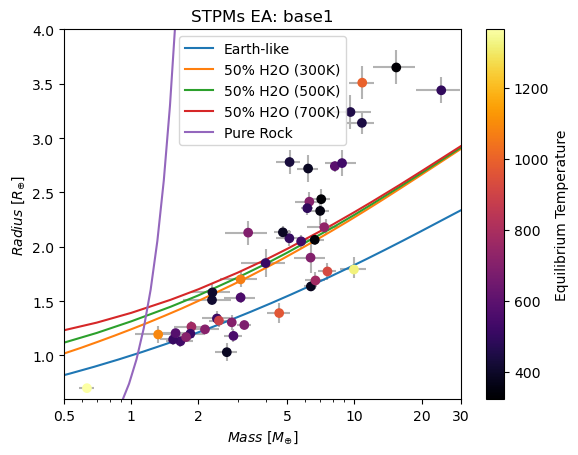

In [49]:
# Plot base1
STPM_candidate_id = STPM_id_base1
mass_up_lim    = abs(dataEA.pl_bmasseerr2[STPM_candidate_id])
mass_low_lim   = abs(dataEA.pl_bmasseerr1[STPM_candidate_id])
mass_err       = [mass_low_lim,mass_up_lim]
radius_up_lim  = dataEA.pl_radeerr1[STPM_candidate_id]
radius_low_lim = abs(dataEA.pl_radeerr2[STPM_candidate_id])
radius_err     = [radius_low_lim,radius_up_lim]
plt.errorbar(mass_EA[STPM_candidate_id], radius_EA[STPM_candidate_id],xerr = mass_err, yerr=radius_err,fmt='.', color='0.7',zorder=-32)
plt.plot(list(earth_like_rocky["Mass"]),list(earth_like_rocky["Radius"]),"-",label = "Earth-like",zorder=-32)
plt.plot(list(H20_50_300K["Mass"]),list(H20_50_300K["Radius"]),"-",label = "50% H2O (300K)",zorder=-32)
plt.plot(list(H20_50_500K["Mass"]),list(H20_50_500K["Radius"]),"-",label = "50% H2O (500K)",zorder=-32)
plt.plot(list(H20_50_700K["Mass"]),list(H20_50_700K["Radius"]),"-",label = "50% H2O (700K)",zorder=-32)
plt.plot(list(pure_rock["Mass"]),list(pure_rock["Radius"]),"-",label = "Pure Rock",zorder=-32)

pure_rock
has_temp_eq_id = []
for i in STPM_candidate_id:
    if pl_eq_EA[i] != "NaN":
        has_temp_eq_id.append(i)

# Create a colorscale based on the equilibrium temperature
norm = plt.Normalize(pl_eq_EA[has_temp_eq_id].min(), pl_eq_EA[has_temp_eq_id].max())
cmap = plt.cm.get_cmap('inferno')
plt.scatter(mass_EA[has_temp_eq_id], radius_EA[has_temp_eq_id], c=pl_eq_EA[has_temp_eq_id], cmap=cmap, norm=norm, marker='o')
cbar = plt.colorbar()
cbar.set_label('Equilibrium Temperature')
plt.xlabel("$Mass\ [M_{\oplus}]$")
plt.ylabel("$Radius\ [R_{\oplus}]$")
plt.xscale("log")
plt.xlim(0.5,30)
plt.ylim(min(radius_EA[STPM_candidate_id])-0.1,4)
plt.xticks([0.5,1,2,5,10,20, 30],["0.5","1","2","5","10","20", "30"],minor=False)
plt.legend()
plt.title("STPMs EA: base1")